In [1]:
import numpy as np
import pandas as pd
import data_lib
import plot_lib
import decision_lib
from sklearn import cluster
import validation_lib
import transform_lib
from icecream import ic
import stats_lib

np.random.seed(200)

In [2]:
# print available data summary
_ = data_lib.explore_datasets(datafolder="../../Data",verbose=True)
print(data_lib.LABELS_LIST)

----------------------------------------------------------------------------------------------
-- The following 4 groups were found
-- They contain 40 datasets
-- The first printed entity is the key to the returned dictionary
-----------------------------------
Group: ../../Data/6P-positive-dilution-series-2-labelled/droplet-level-data/RawData
po-di-se-2-A4, files: 13                po-di-se-2-C4, files: 13                po-di-se-2-A1, files: 13
po-di-se-2-B1, files: 13                po-di-se-2-D1, files: 13                po-di-se-2-B4, files: 13
po-di-se-2-C1, files: 13                po-di-se-2-D4, files: 13                
-----------------------------------
Group: ../../Data/6P-positive-dilution-series-1-labelled/droplet-level-data/RawData
po-di-se-1-D4, files: 13                po-di-se-1-A4, files: 13                po-di-se-1-A1, files: 13
po-di-se-1-D1, files: 13                po-di-se-1-B1, files: 13                po-di-se-1-C1, files: 13
po-di-se-1-B4, files: 13         

### Get samples for negative control

In [3]:

# compute transformation on waste water
df_wa = data_lib.load_dataset(None, [
                                     "wa-sa-A2", 
                                     "wa-sa-B4",
                                     "wa-sa-C4",
                                     "wa-sa-B3",  
                                     "wa-sa-B2",
                                     "wa-sa-A5", 
                                     "wa-sa-A3",
                                     "wa-sa-C2",
                                     "wa-sa-C3", # Pos
                                     "wa-sa-D3", # Zero
                                     "wa-sa-D4", 
                                     "wa-sa-B1", 
                                     "wa-sa-A4",
                                     "wa-sa-A1", 
                                     "wa-sa-D2",
                                     "wa-sa-C5", # Pos
                                     "wa-sa-D5", # Zero
                                     "wa-sa-C1",
                                     ], datafolder="../../Data")
df_negative_control = data_lib.load_dataset([],[
                                                "wa-sa-D3",
                                                "wa-sa-D5"
                                                ], datafolder="../../Data")
np_negative_control = df_negative_control.to_numpy()
np_wa = df_wa.to_numpy(copy=True)[:,:6]


In [4]:
# fix clustering algorithm
prediction_axis = ['SARS-N2_POS','SARS-N1_POS','IBV-M_POS','RSV-N_POS','IAV-M_POS','MHV_POS']
#cluster_engine = cluster.DBSCAN(eps=700, min_samples=5)
whitening_engine = transform_lib.WhitenTransformer(whiten=transform_lib.Whitenings.NONE)
num_cluster = int(2**len(prediction_axis) * 2)
cluster_engine = cluster.KMeans(n_clusters=num_cluster, n_init='auto')
decision = decision_lib.ClusterHierarchyDensityClassifier(
                                     negative_control=np_negative_control,
                                     cluster_algorithm=cluster_engine,
                                     whitening_transformer=whitening_engine,
                                     negative_range=0.95,
                                     eps=0.25,
                                     contamination=0.01,
                                     density_quantile=1,
                                     prediction_axis=prediction_axis,
                                     )
df_decision = decision.predict(np_wa, verbose=1)

Time to remove Negatives: 0.0054416656494140625 seconds.
Time for Clustering: 0.9365973472595215 seconds.
Time for Whitening: 0.04525113105773926 seconds.
Time for Cluster Features: 0.5711216926574707 seconds.
Time for Predictions: 0.29772400856018066 seconds.
Time for Cluster Features (2): 1.9073486328125e-06 seconds.
Time to build Density estimation: 2.5054047107696533 seconds.
Time to compute point probabilies: 2.31829833984375 seconds.


## Plot the predictions

- Black = True negative prediction
- Green = True positive prediciton
- Purple = False negative
- Red = False positive

#### Plot for all diseases predictions against ground truth

Firs plot is in the decorrelated coordinates, whereas the second is in original coordinates

Outlier rate: 0.0003443508067271953, n_outlier: 131

Total error rate: 0.0008888018005281857
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
     0.00008     0.002023   0.002946   0.000023    0.00012 0.000142

Precision (TP / (TP + FP)): 0.9787196777052797
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.998852     0.976473     0.8695        1.0   0.998333 0.999484

Recall / TPR (TP / (TP + FN)): 0.9983138411949316
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999825     0.993322   0.998255        1.0   0.999741      1.0

Specificity / TNR (TN / (TN + FP)): 0.9998706145873284
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
     0.99999     0.999819   0.999429        1.0   0.999988 0.999997

Accuracy ((TP + TN) / (P + N)): 0.9998614033112109
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999989     0.999771   0.999424        1.0   0.999986 0.999997

F1 (2 * (precision 

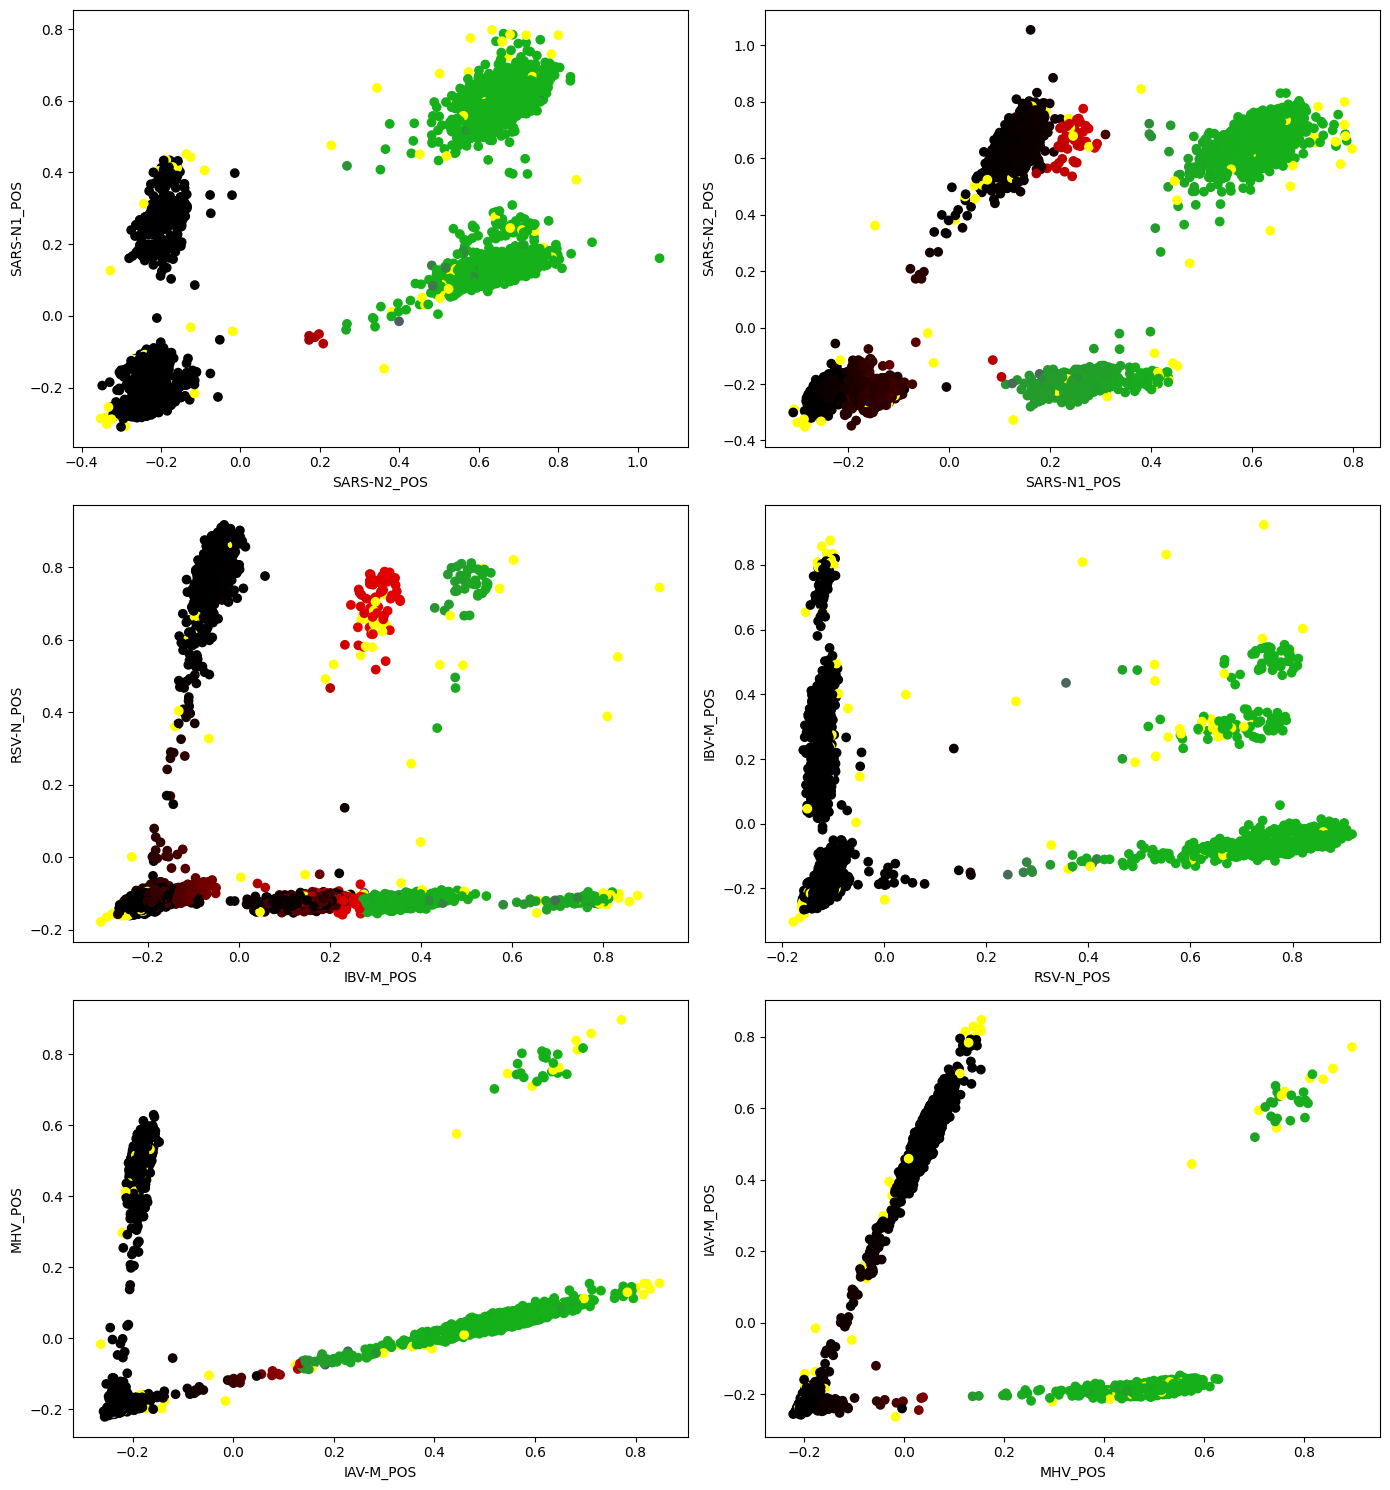

In [5]:

df_data_points = pd.DataFrame(data=decision.X_transformed, columns=prediction_axis) 
df_predictions = decision.probabilities_df
df_ground_trouth = df_wa
selected_pairs = [
                ('SARS-N2_POS','SARS-N1_POS'),
                ('SARS-N1_POS','SARS-N2_POS'),
                ('IBV-M_POS','RSV-N_POS'),
                ('RSV-N_POS','IBV-M_POS'),
                ('IAV-M_POS','MHV_POS'),
                ('MHV_POS','IAV-M_POS'),
                ]

validation_lib.validate_labels(df_ground_trouth, df_predictions, threshold=0.5)

df_result = stats_lib.compute_results(df_predictions, 0.40, 0.60, df_data_points)

plot_lib.plot_pairwise_selection_bayesian(
        df_data_points,
        df_predictions,
        df_ground_trouth,
        selected_pairs,
        n_cols=2,
        mask=decision.No_neg_mask
        )

In [6]:
df_result.to_csv("test_wa.csv")
